<a href="https://colab.research.google.com/github/offani/Speech-Emotion-Recognition/blob/main/(SER).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Speech Emotion Recognition



In [54]:
import librosa
import soundfile
import pandas as pd
import os, glob, pickle
import numpy as np
from tqdm import tqdm

from scipy.io import wavfile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Loading the Dataset (Ravdess)

In [55]:
os.listdir(path='.\Ravdess_Dataset')
def getListOfFiles(dirName):
    listOfFile=os.listdir(dirName)
    allFiles=list()
    for entry in listOfFile:
        fullPath=os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles=allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

dirName = './Ravdess_Dataset'
listOfFiles = getListOfFiles(dirName)
len(listOfFiles)

<>:1: SyntaxWarning: invalid escape sequence '\R'
<>:1: SyntaxWarning: invalid escape sequence '\R'
C:\Users\GAMERS\AppData\Local\Temp\ipykernel_2716\339619780.py:1: SyntaxWarning: invalid escape sequence '\R'
  os.listdir(path='.\Ravdess_Dataset')


2880

# Now Cleaning Step is Performed where: 
#### DOWN SAMPLING OF AUDIO FILES IS DONE  AND PUT MASK OVER IT AND DIRECT INTO CLEAN FOLDER
#### MASK IS TO REMOVE UNNECESSARY EMPTY VOIVES AROUND THE MAIN AUDIO VOICE 


In [56]:
def envelope(y , rate, threshold):
    mask=[]
    y=pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10) ,  min_periods=1 , center = True).mean()
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

# Plotting the Basic Graphs for understanding of Audio Files :
 ## 1) Spectogram

In [57]:
# for file in range(0 , len(listOfFiles) , 1):
#     audio , sfreq = librosa.load(listOfFiles[file])
#     time = np.arange(0 , len(audio)) / sfreq
    
#     fig ,ax = plt.subplots()
#     ax.plot(time , audio)
#     ax.set(xlabel = 'Time  in (s)' , ylabel = 'Amplitude')
#     plt.show()
    
# #PLOT THE SEPCTOGRAM
# for file in range(0 , len(listOfFiles) , 1):
#      sample_rate , samples = wavfile.read(listOfFiles[file])
#      frequencies , times, spectrogram = signal.spectrogram(samples, sample_rate) 
#      plt.pcolormesh(times, frequencies, spectrogram)
#      plt.imshow(spectrogram)
#      plt.ylabel('Frequency [Hz]')
#      plt.xlabel('Time [sec]')
#      plt.show()

# Cleaning the data for efficiency

In [58]:
#Now Cleaning Step is Performed where -
#DOWN SAMPLING OF AUDIO FILES IS DONE  AND PUT MASK OVER IT AND DIRECT INTO CLEAN FOLDER
#MASK IS TO REMOVE UNNECESSARY EMPTY VOIVES AROUND THE MAIN AUDIO VOICE 
def envelope(y , rate, threshold):
    mask=[]
    y=pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10) ,  min_periods=1 , center = True).mean()
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask


#The clean Audio Files are redirected to Clean Audio Folder Directory 
import glob,pickle
for file in tqdm(glob.glob('./Ravdess_Dataset/**/*.wav')):
    file_name = os.path.basename(file)
    signal , rate = librosa.load(file, sr=16000)
    mask = envelope(signal,rate, 0.0005)
    wavfile.write(filename= './clean_speech/'+str(file_name), rate=rate,data=signal[mask])

100%|██████████| 1440/1440 [00:31<00:00, 46.42it/s]


# Extract features (mfcc, chroma, mel) from a sound file

In [59]:
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
        result=np.hstack((result, mel))
    return result

# Emotions in the dataset

In [60]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
#These are the emotions User wants to observe more :
observed_emotions=['calm', 'happy', 'angry', 'disgust']

# Loading the clean data and extracting the data from it 

In [61]:
from glob import glob
import os
import glob
def load_data(test_size=0.33):
    x,y=[],[]
    answer = 0
    for file in glob.glob(r'./clean_speech/*.wav'):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            answer += 1
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append([emotion,file_name])
    return train_test_split(np.array(x), y, test_size=test_size, random_state=0)

#  Splittin the dataset into test and trial data

In [62]:
x_train,x_test,y_train,y_test=load_data(test_size=0.25)
print(np.shape(x_train),np.shape(x_test), np.shape(y_train),np.shape(y_test))
y_test_map = np.array(y_test).T
y_test = y_test_map[0]
test_filename = y_test_map[1]
y_train_map = np.array(y_train).T
y_train = y_train_map[0]
train_filename = y_train_map[1]
print(np.shape(y_train),np.shape(y_test))
print(*test_filename,sep="\n")

(576, 180) (192, 180) (576, 2) (192, 2)
(576,) (192,)
03-01-07-01-02-02-14.wav
03-01-02-02-01-02-03.wav
03-01-02-02-01-01-18.wav
03-01-02-01-01-01-15.wav
03-01-05-02-02-01-02.wav
03-01-02-02-01-01-08.wav
03-01-03-02-02-01-03.wav
03-01-07-01-01-01-13.wav
03-01-05-01-01-01-12.wav
03-01-03-01-01-01-13.wav
03-01-02-01-01-02-08.wav
03-01-05-02-02-01-19.wav
03-01-03-01-02-02-15.wav
03-01-07-01-01-01-18.wav
03-01-07-02-02-01-18.wav
03-01-03-01-01-01-11.wav
03-01-02-02-02-02-08.wav
03-01-02-01-02-01-08.wav
03-01-05-01-02-02-24.wav
03-01-03-02-02-02-06.wav
03-01-05-01-01-02-10.wav
03-01-07-01-01-01-02.wav
03-01-02-02-02-02-05.wav
03-01-03-02-02-01-17.wav
03-01-02-01-01-02-04.wav
03-01-07-01-01-02-06.wav
03-01-03-01-01-02-24.wav
03-01-07-02-02-02-01.wav
03-01-02-01-02-02-08.wav
03-01-05-02-01-01-17.wav
03-01-03-01-02-02-22.wav
03-01-05-01-01-02-15.wav
03-01-07-01-02-01-17.wav
03-01-03-02-02-02-15.wav
03-01-05-01-01-01-02.wav
03-01-05-01-01-01-21.wav
03-01-07-01-02-02-01.wav
03-01-05-02-01-01-21.

# Initialize the Multi Layer Perceptron Classifier 

In [63]:
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

# train the model  

In [64]:

model.fit(x_train,y_train)

,hidden_layer_sizes,"(300,)"
,activation,'relu'
,solver,'adam'
,alpha,0.01
,batch_size,256
,learning_rate,'adaptive'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,500
,shuffle,True
,random_state,None


# Saving this model for future use

In [65]:
import pickle
# Save the Modle to file in the current working directory
#For any new testing data other than the data in dataset

Pkl_Filename = "VoiceEmotionRecogModel.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model, file)

# Loading the Saved Model back for using 

In [66]:
# Load the Model back from file
Pkl_Filename = "VoiceEmotionRecogModel.pkl"
with open(Pkl_Filename, 'rb') as file:  
    VoiceEmotionRecogModel = pickle.load(file)

VoiceEmotionRecogModel

,hidden_layer_sizes,"(300,)"
,activation,'relu'
,solver,'adam'
,alpha,0.01
,batch_size,256
,learning_rate,'adaptive'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,500
,shuffle,True
,random_state,None


# Predicting the y_test values using the loaded Model

In [67]:
#predicting :
y_pred=VoiceEmotionRecogModel.predict(x_test)
y_pred

array(['disgust', 'disgust', 'calm', 'calm', 'angry', 'calm', 'happy',
       'disgust', 'disgust', 'calm', 'calm', 'angry', 'happy', 'disgust',
       'disgust', 'happy', 'calm', 'disgust', 'angry', 'happy', 'angry',
       'disgust', 'calm', 'disgust', 'calm', 'calm', 'happy', 'disgust',
       'calm', 'angry', 'disgust', 'angry', 'disgust', 'happy', 'angry',
       'angry', 'disgust', 'angry', 'angry', 'calm', 'disgust', 'happy',
       'angry', 'angry', 'calm', 'calm', 'happy', 'disgust', 'disgust',
       'disgust', 'disgust', 'calm', 'disgust', 'disgust', 'angry',
       'calm', 'disgust', 'angry', 'calm', 'calm', 'disgust', 'happy',
       'disgust', 'happy', 'happy', 'disgust', 'happy', 'disgust',
       'disgust', 'calm', 'calm', 'disgust', 'happy', 'disgust', 'angry',
       'happy', 'disgust', 'angry', 'disgust', 'angry', 'disgust', 'calm',
       'calm', 'angry', 'disgust', 'happy', 'happy', 'calm', 'happy',
       'disgust', 'disgust', 'happy', 'happy', 'calm', 'angry', 'a

#  Testing the accuracy of this Model 

In [70]:
from sklearn.metrics import accuracy_score

accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

print('Accuracy of this Model = ',accuracy*100,'%')

Accuracy of this Model =  72.91666666666666 %


# Saving the predictions in a .csv file 

In [71]:
import pandas as pd
y_pred1 = pd.DataFrame(y_pred , columns=['Predictions'])
y_pred1['Name of Files'] = test_filename
print(y_pred1)
y_pred1.to_csv('FinalPredictions.csv')

    Predictions             Name of Files
0       disgust  03-01-07-01-02-02-14.wav
1       disgust  03-01-02-02-01-02-03.wav
2          calm  03-01-02-02-01-01-18.wav
3          calm  03-01-02-01-01-01-15.wav
4         angry  03-01-05-02-02-01-02.wav
..          ...                       ...
187       happy  03-01-03-02-02-02-07.wav
188       angry  03-01-03-02-01-01-14.wav
189       happy  03-01-03-02-02-02-23.wav
190        calm  03-01-02-02-01-02-21.wav
191     disgust  03-01-05-01-02-02-08.wav

[192 rows x 2 columns]


In [72]:
y_pred1[:10]

,Predictions,Name of Files
0,disgust,03-01-07-01-02-02-14.wav
1,disgust,03-01-02-02-01-02-03.wav
2,calm,03-01-02-02-01-01-18.wav
3,calm,03-01-02-01-01-01-15.wav
4,angry,03-01-05-02-02-01-02.wav
5,calm,03-01-02-02-01-01-08.wav
6,happy,03-01-03-02-02-01-03.wav
7,disgust,03-01-07-01-01-01-13.wav
8,disgust,03-01-05-01-01-01-12.wav
9,calm,03-01-03-01-01-01-13.wav


#  Demo 


In [73]:
import pyaudio
import wave

CHUNK = 1024 
FORMAT = pyaudio.paInt16 #paInt8
CHANNELS = 2 
RATE = 44100 #sample rate
RECORD_SECONDS = 4
WAVE_OUTPUT_FILENAME = "recordedAudio.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK) #buffer

print("* recording")
frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data) # 2 bytes(16 bits) per channel

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

* recording
* done recording


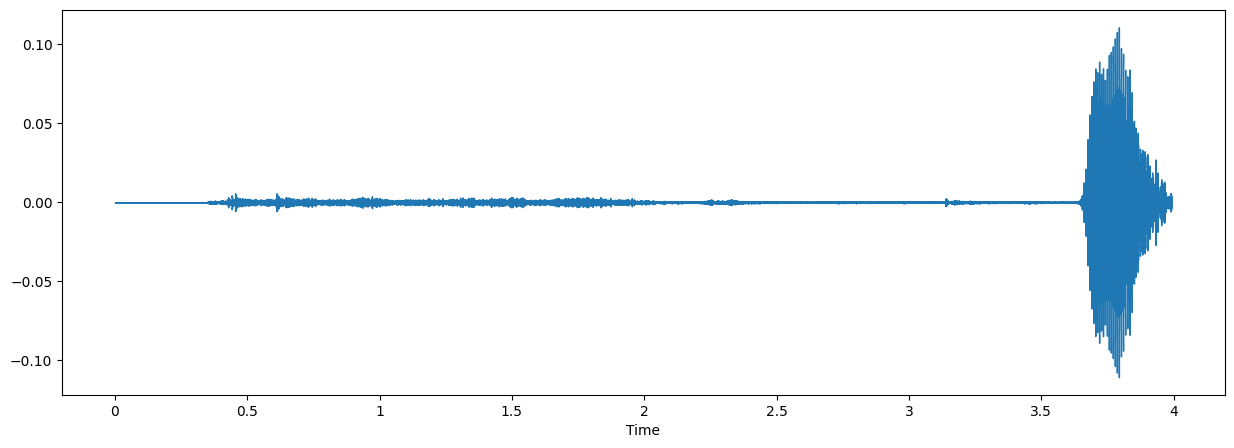

In [74]:
data, sampling_rate = librosa.load('recordedAudio.wav')
# %matplotlib inline
import os
import pandas as pd
import librosa.display
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

## Converting Stereo Audio to Mono Audio

In [75]:
from pydub import AudioSegment

In [76]:
sound =  AudioSegment.from_wav('recordedAudio.wav')
sound = sound.set_channels(1)
sound.export('recordedAudioMono.wav',format='wav')

<_io.BufferedRandom name='recordedAudioMono.wav'>

## Predicting the Speech emotion of recorded audio

In [77]:
file = 'recordedAudioMono.wav'
data , sr = librosa.load(file)
data = np.array(data)
ans =[]
new_feature  = extract_feature(file, mfcc=True, chroma=True, mel=True)
ans.append(new_feature)
ans = np.array(ans)

emt=VoiceEmotionRecogModel.predict(ans)

print ('The emotion from the recorded audio is ',emt[0])

The emotion from the recorded audio is  calm
